In [29]:
import math
import random

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
import kornia as K
from scipy import optimize
import numpy as np

In [30]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

Image Size: torch.Size([28, 28])
tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 100, 237,
         121,   0,   0,   0,   0,   0,   0,  13,  48,  18,   0,   0,   0,   0],
        [  0,

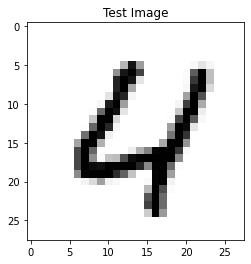

In [31]:
DATASET_PATH = "./data"

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                                AddGaussianNoise(0., .75)])

train_set = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)

TEST_IMG_INDEX = 64

img = train_set.data[TEST_IMG_INDEX]
print(f"Image Size: {img.size()}")
print(img)
plt.title("Test Image")
plt.imshow(img, cmap="Greys")

train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, num_workers=4, pin_memory=True)

In [32]:
input_imgs = torch.clone(train_set.data)
input_imgs.data.to(torch.float)
print(input_imgs.data.size())
noise = torch.rand(input_imgs.data.size(), device=train_set.data.device) * 255

noisy_imgs = input_imgs.data.add(noise.data.int())
noisy_imgs.data.clamp_(min=0, max=511)

clean_img = input_imgs.data[TEST_IMG_INDEX]
noisy_img = noisy_imgs.data[TEST_IMG_INDEX]

noisy_img_removed = torch.clone(noisy_img)

rand_chance = np.random.randint(0, 28, size=28)
rand_lines = np.random.randint(0, 28, size=28)

for i in rand_lines:
    if rand_chance[i] < 9:
        for j in range(noisy_img_removed.size()[0]):
            noisy_img_removed[j][rand_lines[i]] = 0



torch.Size([60000, 28, 28])


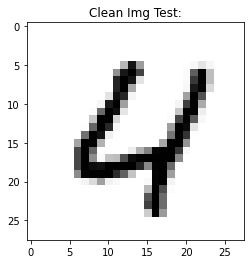

In [33]:
plt.title("Clean Img Test:")
plt.imshow(clean_img, cmap="Greys")

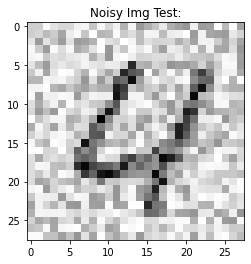

In [34]:
plt.title("Noisy Img Test:")
plt.imshow(noisy_img, cmap="Greys")

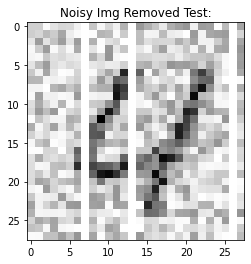

In [35]:
plt.title("Noisy Img Removed Test:")
plt.imshow(noisy_img_removed, cmap="Greys")

In [36]:
ALPHA = 0.1
BETA = 0.1

In [37]:
def forward_differences(u):
    '''
        u: Image matrix of dimensions (y,x)
        returns matrix fu of dimensions (2,y,x)
    '''
    fu = np.zeros( [2] + list(u.shape) )

    fu[0,:-1,:] = u[1:,:] - u[:-1,:]	#y differences (rows-1,cols)
    fu[1,:,:-1] = u[:,1:] - u[:,:-1]	#x differences (rows,cols-1)

    return fu

def backward_differences(u):
    '''
        u: Image matrix of dimensions (y,x)
        returns matrix fu of dimensions (2,y,x)
    '''
    fu = np.zeros( [2] + list(u.shape) )

    fu[0,1:,:] = u[1:,:] - u[:-1,:]	#y differences
    fu[1,:,1:] = u[:,1:] - u[:,:-1]	#x differences

    return fu

def forward_differences_second(u):
    fu = np.zeros( [2] + list(u.shape) )

    fu[0,1:-1,:] = u[0:-2,:] - 2*u[1:-1,:] + u[2:,:]	#y differences
    fu[1,:,1:-1] = u[:,0:-2] - 2*u[:,1:-1] + u[:,2:]	#x differences

    return fu

In [38]:
class TotalGradient:
    def __init__(self,img):
        self.shape = img.shape

        self.gradX = np.zeros( (img.shape[0],img.shape[1]) )
        self.gradY = np.zeros( (img.shape[0],img.shape[1]) )

        self.grad2X = np.zeros( (img.shape[0],img.shape[1]) )
        self.grad2Y = np.zeros( (img.shape[0],img.shape[1]) )

        fd = forward_differences(img[:,:])
        self.gradX[:,:] += fd[0] #dx
        self.gradY[:,:] += fd[1] #dy

        fd2 = forward_differences_second(img[:,:])
        self.grad2X[:,:] += fd2[0] #dx
        self.grad2Y[:,:] += fd2[1] #dy


torch.Size([28, 28])


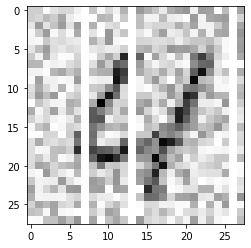

In [39]:
#noisy_img_removed = noisy_img_removed.numpy()
print(noisy_img_removed.shape)
f = noisy_img_removed.numpy()
u = noisy_img_removed.numpy()
f = f.astype("float64")
u = u.astype("float64")
plt.imshow(u, cmap="Greys")

[[147. 146.  19.  97. 132. 126.  56.   0. 169.  39. 131.  56. 204.   0.
  245. 210. 169.  80. 213. 233. 250.  61. 240. 233.   9. 193.   0. 227.]
 [151. 134. 193. 154. 225.  71.  20.   0.   7. 202. 192.  21. 156.   0.
  187.  46.  48. 192.  73.  59.   2. 243.  49. 224. 234. 242.   0. 138.]
 [ 94. 242.  97. 174. 239. 102. 241.   0. 209.  10. 104. 134.   0.   0.
  189. 109. 137. 132. 131. 211. 159. 229.  53.  59. 154. 222.   0. 225.]
 [ 30. 155. 241.  23. 113.  29. 220.   0.  97.   9. 249.  83. 169.   0.
   89.  27. 165. 233.  72.  92. 171.  49. 207.  49. 219. 228.   0. 250.]
 [ 47.  26. 165. 107. 126.  89.  77.   0. 206. 127. 253.  39.   8.   0.
  138. 134. 116. 114. 134.  72. 136. 168. 167. 187. 113.  27.   0. 237.]
 [ 96. 189. 242. 116.  83. 122. 104.   0.  87. 107.  70.  75. 143.   0.
  203. 215. 132. 157. 253. 238. 243. 219. 140. 234. 159.  22.   0. 242.]
 [161.  54. 226.  87.   7.  21. 137.   0.  18. 149. 226. 148. 439.   0.
  348.  18. 232. 132.  31. 186.  61. 306. 407. 293. 136.  

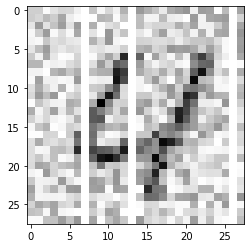

In [40]:
print(u)
for i in range (0, 2560000):
    TG = TotalGradient(u)
    TGX2 = TotalGradient(TG.gradX / np.sqrt(TG.gradX**2 + 1e-4))
    TGY2 = TotalGradient(TG.gradY / np.sqrt(TG.gradY**2 + 1e-4))
    s = (0.1* TGX2.gradX + 0.25 * TGY2.gradY + (f - u))
    u = s * 0.01 + u

print(u)
plt.imshow(u, cmap="Greys")

In [41]:
class Energy:
    def __init__(self, f, u, alpha, beta, learning_rate):
        self.f = f
        self.u = u
        self.alpha = alpha
        self.beta = beta
        self.learning_rate = learning_rate
        self.img_shape = f.shape
        self.img_size = f.size

    def fn_jac(self, u):
        _u = f.reshape(self.img_shape)
        TG = TotalGradient(_u)
        TGX2 = TotalGradient(TG.gradX / np.sqrt(TG.gradX**2 + 1e-4))
        TGY2 = TotalGradient(TG.gradY / np.sqrt(TG.gradY**2 + 1e-4))

        S =  (self.alpha* TGX2.gradX.any() + self.beta * TGY2.gradY.any() + (f - _u))
        return S

    def energy(self, u):
        _u = u.reshape(self.img_shape)
        TG = TotalGradient(_u)

        E = np.sum(self.alpha * np.abs(TG.gradX.any()) + self.beta * np.abs(TG.gradY.any()) + 0.5 * ((f - _u)**2))
        return E

In [42]:
E = Energy(f, u, 0.01, 0.05, 1e-3)
max_it = 100000
print(E.fn_jac(u))
solution=optimize.minimize(lambda u: E.energy(u),np.zeros(E.f.size,),jac=lambda u: E.fn_jac(u),method="CG",options={"maxiter":max_it})

x = solution["x"].reshape(f.shape)
print(x)

plt.imshow(x, cmap="Greys")


[[0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06
  0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06]
 [0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06
  0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06]
 [0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06
  0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06]
 [0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06
  0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06]
 [0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06
  0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06]
 [0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06
  0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06]
 [0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06
  0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()